In [9]:
from keras import Model, backend, initializers, layers, models
from keras.optimizers import Adam
from models import load_model
from readers import generate_datasets
import joblib
import numpy as np
from keras.layers import TextVectorization
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from pathlib import Path
from sklearn.model_selection import train_test_split


def create_embedding_layer(voc, shape, model):
    word_index = dict(zip(voc, range(len(voc))))
    num_tokens = len(voc) + 2
    embedding_dim = shape[1]  # dimension of vectors
    hits = 0
    misses = 0

    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        try:
            embedding_vector = model.get_vector(word)
            embedding_matrix[i] = embedding_vector
            hits += 1
        except KeyError:
            misses += 1

    return layers.Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=initializers.Constant(embedding_matrix),
        trainable=False,
        input_shape=[None],
        mask_zero=True,
    )

best_path = "./results/cnn_lstm/nkjp+wiki-lemmas-all-100-cbow-hs.txt/clean+no_stopwords.pkl"
best_res = joblib.load(best_path)

learning_rate = best_res.best_trial.params["learning_rate"]
first_layer_size = best_res.best_trial.params["lstm_first_layer_size"]
second_layer_size = best_res.best_trial.params["lstm_second_layer_size"]
df = pd.concat(
    [
        pd.read_csv("data/dane treningowe_I etap.csv"),
        pd.read_csv("data/dane testowe.csv"),
    ]
)
word2vec_model = load_model(Path("models/word2vec/nkjp+wiki-lemmas-all-100-cbow-hs.txt"))
dataset = generate_datasets(df)
label_binarizer = LabelBinarizer()
bin_y = label_binarizer.fit_transform(df["class"])
x = dataset["clean+no_stopwords"]
shape = word2vec_model.vectors.shape
vectorizer = TextVectorization(
    max_tokens=shape[0], output_sequence_length=int(x.str.split().str.len().max())
)
vectorizer.adapt(x)
# dict mapping words to their indices
voc = vectorizer.get_vocabulary()

# create embedding layer
vectorized_x = vectorizer(np.array([[s] for s in x])).numpy()
embedding_layer = create_embedding_layer(voc, shape, word2vec_model)

nkjp+wiki-lemmas-all-100-cbow-hs.txt
('clean',)
('clean', 'no_stopwords')
{'wami', 'takie', 'no', 'tę', 'te', 'tobą', 'możliwe', 'mają', 'ok', 'został', 'dlaczego', 'wasze', 'ktorych', 'nad', 'może', 'tych', 'ach', 'nawet', 'jej', 'inna', 'totobą', 'który', 'inny', 'sposób', 'powinno', 'juz', 'jest', 'często', 'razie', 'zadnych', 'wszystkim', 'xii', 'którego', 'jak', 'wtedy', 'ten', 'jaki', 'których', 'zapewne', 'ich', 'kto', 'niż', 'wasz', 'raz', 'aj', 'dla', 'vii', 'czy', 'rowniez', 'ktorym', 'jakiś', 'obok', 'jakoś', 'dlatego', 'sie', 'też', 'przy', 'aczkolwiek', 'godz', 'nasi', 'on', 'poniewaz', 'dziś', 'wy', 'one', 'ponieważ', 'niech', 'twoj', 'naszego', 'bowiem', 'wielu', 'twoje', 'żadna', 'owszem', 'była', 'jezeli', 'bardziej', 'ja', 'sobie', 'bez', 'powinni', 'wie', 'kiedy', 'u', 'ktorzy', 'albo', 'był', 'zaś', 'tylko', 'ależ', 'ktoś', 'cali', 'nic', 'coś', 'chce', 'ktokolwiek', 'viii', 'ku', 'ile', 'iv', 'jakiz', 'twój', 'zostal', 'bym', 'przecież', 'temu', 'teraz', 'wszystkic

In [6]:
model = models.Sequential(
    [
        embedding_layer,
        layers.Bidirectional(
            layers.LSTM(
                first_layer_size,
                return_sequences=True,
            ),
        ),
        layers.Conv1D(
            second_layer_size,
            kernel_size=3,
            activation="relu",
            padding="same",
        ),
        layers.GlobalMaxPooling1D(),
        layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=learning_rate),
    metrics=["acc"],
)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(vectorized_x, bin_y, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, batch_size=256, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
25/25 [==============================] - 10s 92ms/step - loss: 0.5891 - acc: 0.6880 - val_loss: 0.5213 - val_acc: 0.7248
Epoch 2/100
25/25 [==============================] - 1s 31ms/step - loss: 0.4577 - acc: 0.7775 - val_loss: 0.5042 - val_acc: 0.7422
Epoch 3/100
25/25 [==============================] - 1s 30ms/step - loss: 0.3977 - acc: 0.8111 - val_loss: 0.4867 - val_acc: 0.7578
Epoch 4/100
25/25 [==============================] - 1s 31ms/step - loss: 0.3323 - acc: 0.8538 - val_loss: 0.4818 - val_acc: 0.7642
Epoch 5/100
25/25 [==============================] - 1s 38ms/step - loss: 0.2740 - acc: 0.8804 - val_loss: 0.5025 - val_acc: 0.7713
Epoch 6/100
25/25 [==============================] - 1s 34ms/step - loss: 0.2433 - acc: 0.9001 - val_loss: 0.5570 - val_acc: 0.7623
Epoch 7/100
25/25 [==============================] - 1s 26ms/step - loss: 0.2086 - acc: 0.9163 - val_loss: 0.5659 - val_acc: 0.7713
Epoch 8/100
25/25 [==============================] - 1s 29ms/step - loss: 0

In [8]:
vocab = vectorizer.get_vocabulary()
vocab_arr = np.asarray(vocab)

NameError: name 'vectorizer' is not defined

In [6]:
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer


vectorizer.transform = lambda x: pd.DataFrame(vectorizer.__call__(x))
c = make_pipeline(vectorizer, model)
explainer = LimeTextExplainer()
result_exp = []
num_features = len(vocab)
range_ = X_valid.shape[0]
for i in range(range_):
    print(str(i) + "/" + str(range_))213
    res = " ".join(vocab_arr[X_valid[i]])
    exp = explainer.explain_instance(res, c.predict, num_features=num_features, labels=(0, ))
    result_exp.append(exp.local_exp[0])

dest_path = Path("impretability_res.pkl")
with dest_path.open("wb") as dest_file:
    joblib.dump(result_exp, dest_file)

NameError: name 'res' is not defined

In [10]:
vocab = vectorizer.get_vocabulary()
vocab_arr = np.asarray(vocab)
res = {}
counter = {}
data = joblib.load("impretability_res.pkl")
for record in data:
    print(record)
    for row in record:
        if row[0] not in res.keys():
            res[row[0]] = 0
            counter[row[0]] = 0

        res[row[0]] += row[1]
        counter[row[0]] += 1

result = {}
for num in res.keys():
    result[num] = res[num]/counter[num]

df = vocab_arr[list(result.keys())]
df = pd.DataFrame(df)
df["val"] = result.values()

%matplotlib inline
df = df.sort_values("val")

[(24, 0.21628579320479593), (43, -0.2129860262390396), (48, 0.15022930179878388), (10, -0.13927571100224712), (12, 0.11092135458200622), (42, -0.10951959140751696), (27, -0.09757101303631155), (18, 0.08824426121675084), (26, 0.07636011877365745), (47, -0.05805687872203285), (25, 0.05792143777622337), (5, 0.05594544763032483), (17, 0.04929982212558806), (13, 0.04306943246255819), (39, 0.042336448607889154), (22, 0.039684475339058146), (19, 0.03743095214253862), (23, 0.037164947608266836), (1, 0.03373182716526125), (16, 0.03367689413782591), (21, 0.030812024275036834), (20, 0.0308014465182546), (38, 0.03077721334345976), (30, 0.027056872223530145), (52, 0.026393912927189865), (15, 0.025296009489199793), (51, 0.025171994478854105), (55, -0.024238777415935834), (41, 0.02314842300243974), (33, 0.021920343644171166), (6, 0.021681172180150938), (40, 0.019231680818259943), (54, 0.01703941899686771), (3, 0.015082378196633535), (34, 0.01503207915438212), (2, 0.014858007367242396), (31, 0.0145280

In [23]:
dest_path = Path("impretability_res.pkl")
with dest_path.open("wb") as dest_file:
    joblib.dump(df, dest_file)


,0,val
75,należy,-0.030254
32,szkoły,-0.018896
51,umowę,-0.016881
39,rachunku,-0.015755
24,sąd,-0.014584
...,...,...
66,opłata,0.022707
78,okresu,0.026347
74,przyczyn,0.026451
73,zobowiązuje,0.051381


<AxesSubplot: xlabel='val', ylabel='0'>

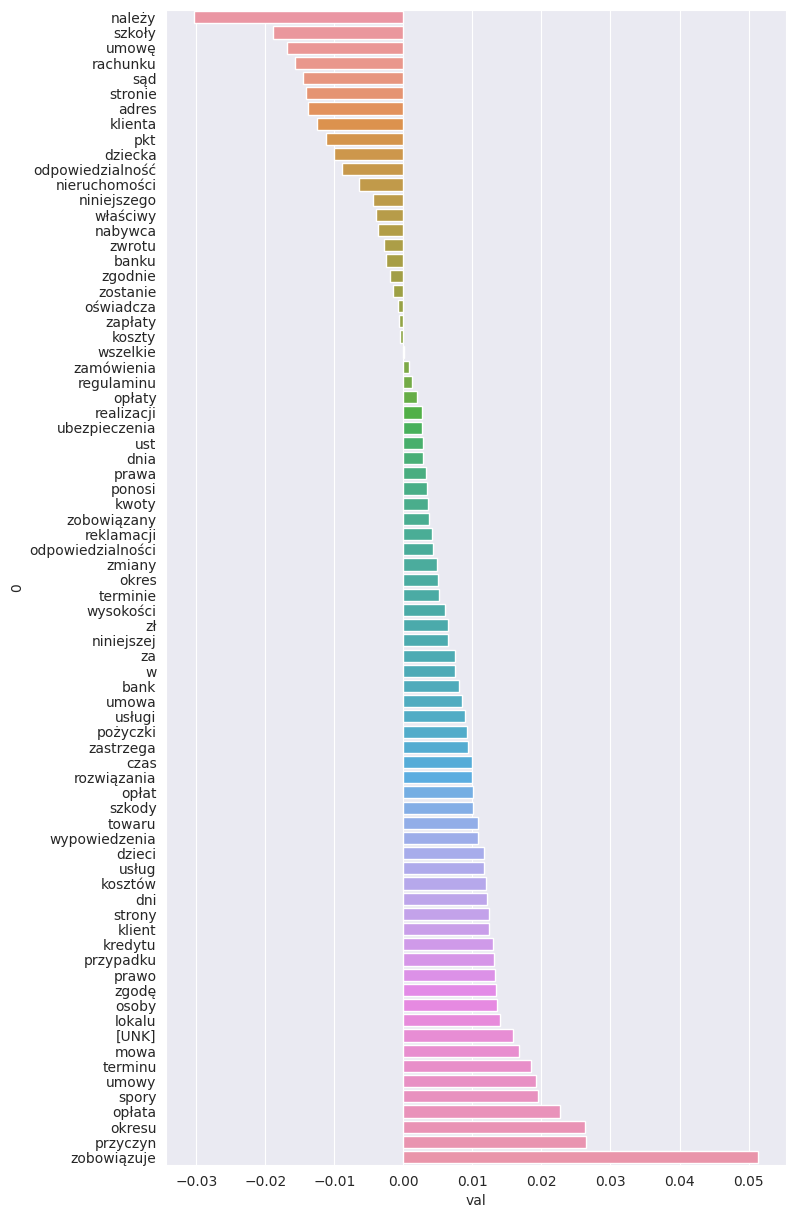

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

%matplotlib inline
df = joblib.load("impretability_res.pkl")
df = df.drop(57)
df = df.drop(55)
df = df.drop(6)
df = df.drop(0)
df = df.drop(53)
plt.figure(figsize=(8, 15
                    ))
#plt.xticks(rotation=45, ha="right")

plt.grid(visible=True, which="both", axis="both")
sns.barplot(x=df["val"], y=df[0])